# RXRX.AI

> disclosure: some lines of code were taken from other kernels available on the Kaggle's competition link https://www.kaggle.com/c/recursion-cellular-image-classification/kernels . Authors will be cited as much as possible where appropriate.

In [1]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 71kB 4.0MB/s 
    100% |████████████████████████████████| 61kB 21.7MB/s 
    100% |████████████████████████████████| 102kB 10.7MB/s 
    100% |████████████████████████████████| 81kB 26.4MB/s 
    100% |████████████████████████████████| 2.9MB 13.1MB/s 
    100% |████████████████████████████████| 81kB 29.2MB/s 
    100% |████████████████████████████████| 102kB 32.5MB/s 
    100% |████████████████████████████████| 102kB 33.3MB/s 
    100% |████████████████████████████████| 81kB 29.0MB/s 
    100% |████████████████████████████████| 1.2MB 19.0MB/s 
    100% |████████████████████████████████| 153kB 34.7MB/s 
    100% |████████████████████████████████| 51kB 21.8MB/s 
    100% |████████████████████████████████| 419kB 30.5MB/s 
    100% |████████████████████████████████| 92kB 27.1MB/s 
    100% |████████████████████████████████| 92kB 25.6MB/s 
    100% |████████████████████████████████| 102kB 27.1MB/s 
    100% |████████████████████████████████| 163kB

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rxrx.io as rio
from scipy import misc

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

from torchvision import models, transforms

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Data folder overview
!ls -1 ./data

pixel_stats.csv
recursion_dataset_license.pdf
sample_submission.csv
test
test.csv
test_controls.csv
train
train.csv
train_controls.csv


## Loading a site and visualizing individual channels

This exploration is inspired by the competition's [creator notebook](https://colab.research.google.com/github/recursionpharma/rxrx1-utils/blob/master/notebooks/visualization.ipynb) and [utils](https://github.com/recursionpharma/rxrx1-utils).   
  
The input for our model will be a 512x512x6 image tensor representing a site, so we will make sure the utilities provided load the site as a tensor with the proper shape. Here, we request the image in experiment RPE-05 on plate 3 in well D19 at site 2.

In [3]:
t = rio.load_site('train', 'RPE-05', 3, 'D19', 2, base_path="./data")
print(t.shape)
t_tensor = transforms.ToTensor()(t)
print(t_tensor.shape)

(512, 512, 6)
torch.Size([6, 512, 512])


This seems to work, now let's visualize individual channels.

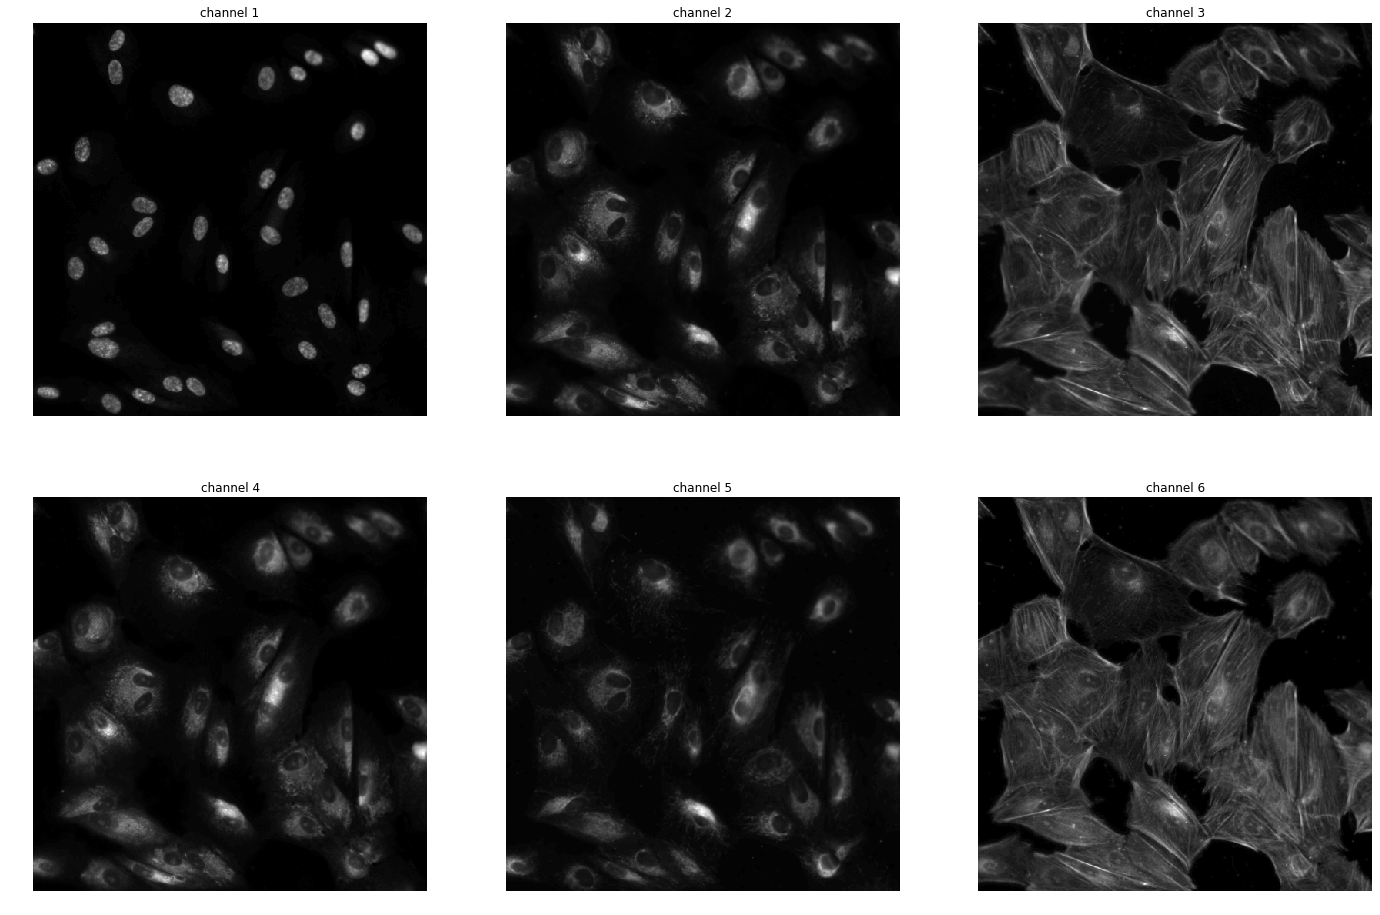

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')
  ax.set_title('channel {}'.format(i + 1))
  _ = ax.imshow(t[:, :, i], cmap='gray')

With the utils provided, we can also convert a site to a RGB format with the `convert_tensor_to_rgb` method. It associates an RGB color with each channel, then aggregates the color channels across the six cellular channels.   

(512, 512, 3)


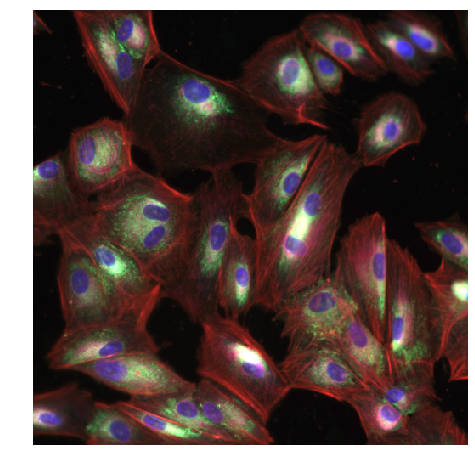

In [5]:
x = rio.convert_tensor_to_rgb(t)
print(x.shape)

# plot RGB Image
plt.figure(figsize=(8, 8))
plt.axis('off')
_ = plt.imshow(x)

The utils also include a wrapper `load_site_as_rgb` combining the last two functions.

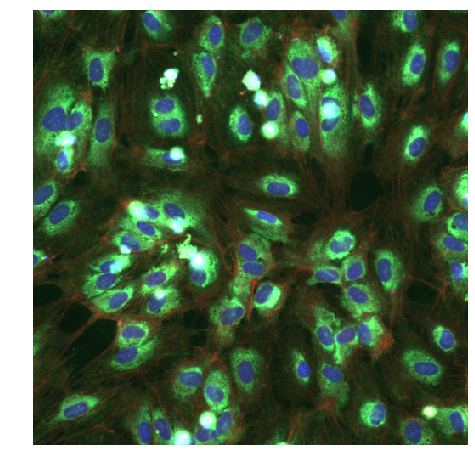

In [6]:
y = rio.load_site_as_rgb('train', 'HUVEC-07', 4, 'K09', 1)

plt.figure(figsize=(8, 8))
plt.axis('off')

_ = plt.imshow(y)

In [7]:
# convert to Tensor
y_tensor = transforms.ToTensor()(y)
print(y_tensor.shape)

torch.Size([3, 512, 512])


## Metadata

The metadata for RxRx1 during the Kaggle competition is broken up into four files: train.csv, train_controls.csv, test.csv and test_controls.csv. It is often more convenient to view all the metadata at once, so we have provided a helper function called combine_metadata for doing just that.

In [8]:
md = rio.combine_metadata()
md.head()

,cell_type,dataset,experiment,plate,sirna,site,well,well_type
id_code,,,,,,,,
HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,1138.0,1,B02,negative_control
HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,1138.0,2,B02,negative_control
HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,NaN,1,B03,treatment
HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,NaN,2,B03,treatment
HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,NaN,1,B04,treatment


## Model baseline

In [2]:
path_data = './data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)
classes = 1108
batch_size = 16

cuda


### Implement dataset class & loaders

In [3]:
class ImagesDS(D.Dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def __init__(self, df, img_dir='./data', mode='train', site=1, channels=[1,2,3,4,5,6]):
        self.records = df.to_records(index=False)
        self.channels = channels
        self.site = site
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        
    def _get_img(self, index):
        record = self.records[index]
        return transforms.ToTensor()(rio.load_site_as_rgb(self.mode, record.experiment, record.plate, record.well, self.site)).float().cuda()
        
    def __getitem__(self, index):
        img = self._get_img(index)
        if self.mode == 'train':
            return img, int(self.records[index].sirna)
        else:
            return img, self.records[index].id_code

    def __len__(self):
        return self.len

In [4]:
df = pd.read_csv(path_data+'/train.csv')
df_train, df_val = train_test_split(df, test_size = 0.025, random_state=42)
df_test = pd.read_csv(path_data+'/test.csv')

In [5]:
ds = ImagesDS(df_train, path_data, mode='train')
ds_val = ImagesDS(df_val, path_data, mode='train')
ds_test = ImagesDS(df_test, path_data, mode='test')

In [6]:
loader = D.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=0)
tloader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

### Prepare model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(16 * 32 * 32, 1108, bias=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 32 * 32)
        x = self.fc1(x)
        return x

model = Net()
model.cuda()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (fc1): Linear(in_features=16384, out_features=1108, bias=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

metrics = {
    'loss': Loss(criterion),
    'accuracy': Accuracy(),
}

print("Training started")
for epoch in range(1,6):  # loop over the dataset multiple times
    running_loss = 0.0
    print(f'epoch {epoch}')
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 9))
            running_loss = 0.0

print('Finished Training')

Training started
epoch 1


In [ ]:
model.eval()
with torch.no_grad():
    preds = np.empty(0)
    for x, _ in tqdm_notebook(tloader): 
        x = x.to(device)
        output = model(x)
        idx = output.max(dim=-1)[1].cpu().numpy()
        preds = np.append(preds, idx, axis=0)

In [ ]:
submission = pd.read_csv(path_data + '/test.csv')
submission['sirna'] = preds.astype(int)
submission.to_csv('submission_base.csv', index=False, columns=['id_code','sirna'])

<a href="submission_base.csv">Download submission file for Base Model</a>